In [2]:
from ISUP_test.Functions.sklearn_plots import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import cv2
import os
import time
import multiprocessing
import gc
import warnings

from collections import Counter
from joblib import Parallel, delayed, dump, load
from shapely.geometry.polygon import Polygon
from functions import *

from skimage import data
from skimage import morphology
from skimage import measure
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, peak_local_max, canny, hog
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb, rgb2gray, label2rgb, gray2rgb, rgb2lab, rgb2yuv
from skimage.util import crop, img_as_ubyte, img_as_float, invert
from skimage.filters import threshold_otsu, threshold_local, rank, sobel
from skimage.segmentation import clear_border
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.transform import match_histograms

from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit,ShuffleSplit,cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.datasets import load_sample_image
from sklearn.pipeline import make_pipeline

from scipy.interpolate import UnivariateSpline
from scipy import ndimage as ndi
from scipy.spatial import Delaunay, ConvexHull

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.colors import LinearSegmentedColormap
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white','navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet','white'])

## Image normalization and stain separation 

In [4]:
image = imread('/home/tien/Documents/projets/histopathology/ISUP_test/ISUP_images/GS_33/255_20X_2.jpg') # 549_20X, 207_20X_2
ref = imread('/home/tien/Documents/projets/histopathology/ISUP_test/ISUP_images/GS_34/281_20X.jpg')
matched = match_histograms(image, ref, multichannel=True)
image_hed = rgb2hed(matched)

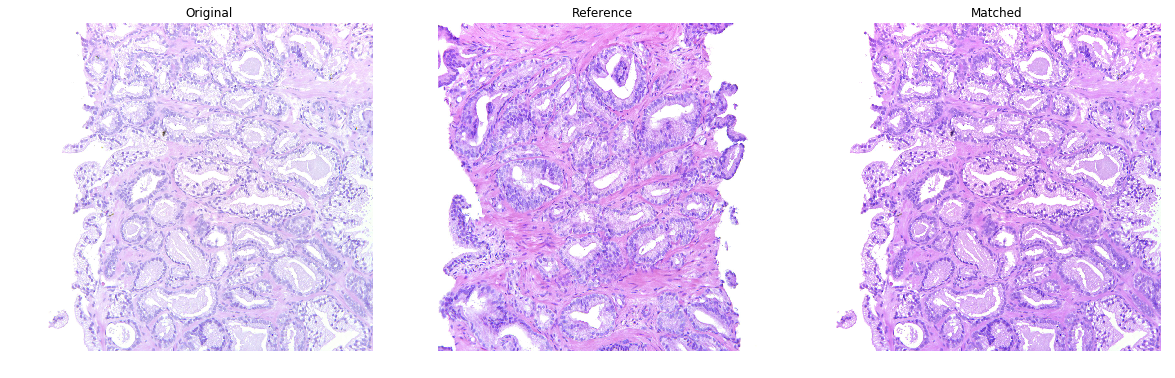

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,15), sharex=True, sharey=True)

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(ref)
ax[1].set_title('Reference')

ax[2].imshow(matched)
ax[2].set_title('Matched')

for a in ax:
    a.axis('off')
plt.show()

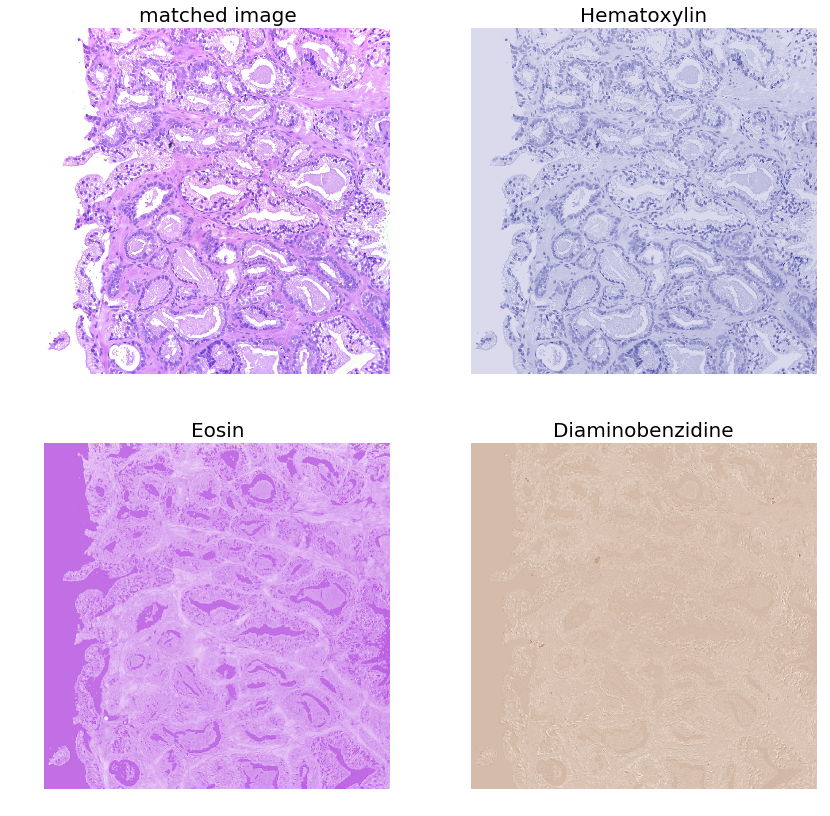

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(matched)
ax[0].set_title("matched image", fontsize=20)

ax[1].imshow(image_hed[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin", fontsize=20)

ax[2].imshow(image_hed[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin", fontsize=20)

ax[3].imshow(image_hed[:, :, 2], cmap=cmap_dab)
ax[3].set_title("Diaminobenzidine", fontsize=20)

for a in ax.ravel():
    a.axis('off')

#fig.tight_layout()
plt.show()

## Nuclei and stroma masks from hematoxylin and eosin channels

In [5]:
block_size = 75
offset = 10

eosin = img_as_ubyte(rescale_intensity(image_hed[:,:,1], out_range=(1,0)))
thresh_eosin = threshold_otsu(eosin)
binary_eosin = np.bitwise_not((eosin > thresh_eosin))

# Local threshold pour les noyaux : permet de mieux discerner les noyaux individuellement (pas un gros blob)
hema = img_as_ubyte(rescale_intensity(image_hed[:,:,0], out_range=(1,0)))
local_thresh_hema = threshold_local(hema, block_size=block_size, offset=offset)
binary_hema = hema > local_thresh_hema

# Noise reduction : morphological operations and thresholding

selem = morphology.disk(2)
closed_img = morphology.binary_closing(binary_hema, selem=selem)
closed_opened_img = np.bitwise_not(morphology.binary_opening(closed_img, selem=selem))

# Marker-based watershed segmentation : separate overlapping nuclei
distance = ndi.distance_transform_edt(closed_opened_img)
local_max = peak_local_max(distance, min_distance=8, indices=False, labels=closed_opened_img)
markers = ndi.label(local_max)[0]
labels_watershed = morphology.watershed(-distance, markers, mask=closed_opened_img, compactness=0.01, watershed_line=True)
props = measure.regionprops(labels_watershed)
list_areas = [props[i].area for i in range(len(props))]
avg_area = np.mean(np.array(list_areas))
labels_final = morphology.remove_small_objects(labels_watershed, min_size=0.20*avg_area)
props_final = measure.regionprops(labels_final, coordinates='rc')

nuclei_mask = (labels_final > 0).astype(np.int8)
eosin_mask = morphology.binary_closing(np.bitwise_and(binary_eosin, np.invert(nuclei_mask)), selem=selem).astype(np.int8)

/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


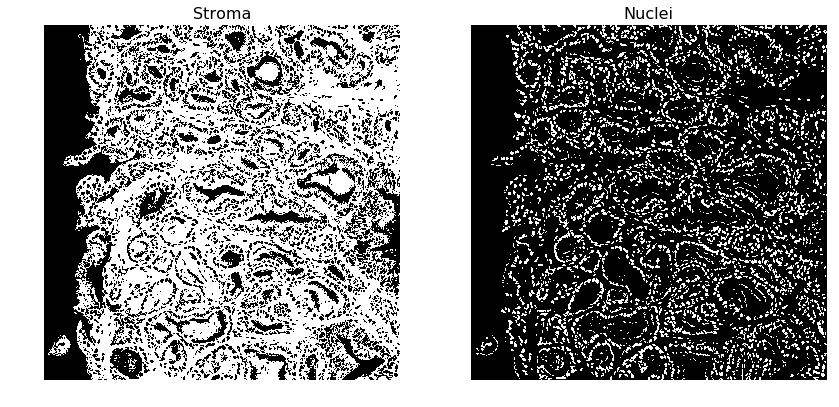

In [26]:
f, ax = plt.subplots(1,2, figsize=(14,12), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].imshow(eosin_mask, cmap=plt.cm.gray)
ax[0].set_title('Stroma', fontsize=BIGGER_SIZE)
ax[1].imshow(nuclei_mask, cmap=plt.cm.gray)
ax[1].set_title('Nuclei', fontsize=BIGGER_SIZE)

for a in ax:
    a.axis('off')
plt.show()

### Lumen mask from _k_-means clustering (example taken from scikit-learn)

In [6]:
n_colors = 3

w, h, d = original_shape = tuple(matched.shape)
assert d == 3
image_array = np.reshape(matched, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time.time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time.time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time.time()
labels_rgb = kmeans.predict(image_array)
print("done in %0.3fs." % (time.time() - t0))

Fitting model on a small sub-sample of the data
done in 0.869s.
Predicting color indices on the full image (k-means)
done in 1.243s.


In [7]:
# Façon d'aller chercher le cluster du lumen trouvé par k-means (pcq l'ordre des clusters change à chaque fois que k-means est utilisé)
white_cluster = [255, 255, 255]
clusters = np.array([[0,0,0], [0,0,0], [0,0,0]]) # shape (3,3)
distances = [np.linalg.norm(kmeans.cluster_centers_.astype(int)[i] - white_cluster) for i in range(n_colors)]
lumen_cluster_number = np.argmin(distances)
clusters[lumen_cluster_number] = white_cluster

clustered_lumen = recreate_image(clusters, labels_rgb, w, h)
bool_lumen = rgb2gray(clustered_lumen).astype(bool)
lumen_mask = morphology.binary_closing(bool_lumen, selem=morphology.disk(1)).astype(int)

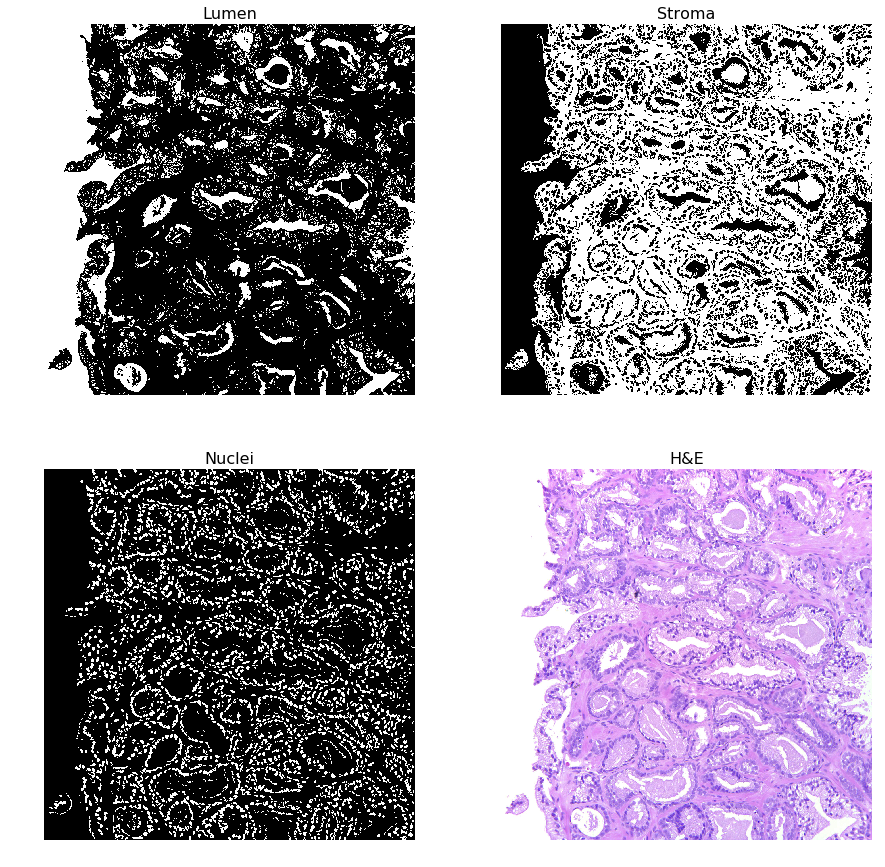

In [27]:
f, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].imshow(lumen_mask, cmap=plt.cm.gray)
ax[0].set_title('Lumen', fontsize=BIGGER_SIZE)

ax[1].imshow(eosin_mask, cmap=plt.cm.gray)
ax[1].set_title('Stroma', fontsize=BIGGER_SIZE)

ax[2].imshow(nuclei_mask, cmap=plt.cm.gray)
ax[2].set_title('Nuclei', fontsize=BIGGER_SIZE)

ax[3].imshow(matched)
ax[3].set_title('H&E', fontsize=BIGGER_SIZE)

for a in ax:
    a.axis('off')
plt.show()

#### <span style="color:red"> Counting of stroma/lumen pixels, neighborhood nuclei around every nucleus + their morphology </span>

In [8]:
# Une map contenant l'emplacement des centroïdes.
# Elle sera utilisée dans le comptage de noyaux voisins dans chaque itération de "patch" de (50 x 50 pixels)
centroids = np.zeros((matched.shape[0], matched.shape[1]))
for i in range(len(props_final)):
    r, c = props_final[i].centroid
    centroids[int(r), int(c)] = 1

nuclei_morphology = np.empty((0,1))
max_distances = np.empty((0,5)) # max distance voisin pour 3 steps, moyenne et std
min_distances = np.empty((0,5)) # min distance voisin pour 3 steps, moyenne et std
neighbors = np.empty((0,5)) # qté de voisins pour 3 steps, moyenne et std

stroma_per_nucleus = np.empty((0,5)) # qté de stroma pour 3 steps, moyenne et std
lumen_per_nucleus = np.empty((0,5)) # qté de lumière pour 3 steps, moyenne et std

steps = [30, 50, 70]

for i in range(len(props_final)):
    r, c = props_final[i].centroid
    nuclei_morphology = np.vstack((nuclei_morphology, props_final[i].convex_area))
    stroma = []
    lumen = []
    max_distances_temp = []
    min_distances_temp = []
    neighbors_temp = []
    
    for step in steps :
        if int(r)-step < 0 :
            row_start = 0
        else :
            row_start = int(r)-step

        if int(r)+step > matched.shape[0] :
            row_stop = matched.shape[0]
        else :
            row_stop = int(r)+step

        if int(c)-step < 0 :
            col_start = 0
        else :
            col_start = int(c)-step

        if int(c)+step > matched.shape[1] :
            col_stop = matched.shape[1]
        else :
            col_stop = int(c)+step

        range_row = slice(row_start, row_stop)
        range_col = slice(col_start, col_stop)
        slices = (range_row, range_col)

        indices = np.transpose(np.nonzero(centroids[slices])) # Retourne la position des centroïdes
        indices[:,0] = indices[:,0] + row_start # Conversion des indices des noyaux dans la région des slices en indices de l'image totale (pour utiliser avec centroïde d'intérêt)
        indices[:,1] = indices[:,1] + col_start
        position, = np.where(np.all(indices == [int(r),int(c)], axis=1))[0] # Retourne l'indice du centroïde d'intérêt dans la région slice
        indices = np.delete(indices, position, axis=0) # Supprime la coordonnée du centroïde et garde juste les centroïdes voisins

        if len(indices) == 0 : # Pas de centroïdes voisins
            distances = 0
            max_distance = 10000
            min_distance = -1
            num_neighbors = len(indices)
        else :
            distances = [np.linalg.norm(indices[i]-[int(r),int(c)]) for i in range(len(indices))] # Calcule la distance entre centroïde d'intérêt et ses voisins
            max_distance = np.max(distances)
            min_distance = np.min(distances)
            num_neighbors = len(indices)
        
        max_distances_temp.append(max_distance)
        min_distances_temp.append(min_distance)
        neighbors_temp.append(num_neighbors)
        
        stroma.append(np.sum(eosin_mask[slices]))
        lumen.append(np.sum(lumen_mask[slices]))
    
    max_distances_temp.extend([np.mean(max_distances_temp), np.std(max_distances_temp)])
    min_distances_temp.extend([np.mean(min_distances_temp), np.std(min_distances_temp)])
    neighbors_temp.extend([np.mean(neighbors_temp), np.std(neighbors_temp)])
    
    max_distances = np.vstack((max_distances, max_distances_temp))
    min_distances = np.vstack((min_distances, min_distances_temp))
    neighbors = np.vstack((neighbors, neighbors_temp))
    
    stroma.extend([np.mean(stroma), np.std(stroma)])
    lumen.extend([np.mean(lumen), np.std(lumen)])
        
    stroma_per_nucleus = np.vstack((stroma_per_nucleus, stroma))
    lumen_per_nucleus = np.vstack((lumen_per_nucleus, lumen))

    
all_features = np.hstack((stroma_per_nucleus, lumen_per_nucleus, max_distances, min_distances, neighbors, nuclei_morphology)) # shape : (# nuclei x 26 features)

In [9]:
all_features.shape

(4537, 26)

## Attempt to classify epithelial and non-epithelial nuclei with _k_-means clustering with the neighborhood features

In [8]:
n_typenuclei = 2
print("Fitting model on a small sub-sample of the data")
t0 = time.time()
features_sample = shuffle(all_features, random_state=0)[:int(0.8*all_features.shape[0])] # 80% du dataset pour train
kmeans = KMeans(n_clusters=n_typenuclei, random_state=0).fit(features_sample)
print("done in %0.3fs." % (time.time() - t0))

# Get labels for all points
print("Predicting nuclei type (k-means)")
t0 = time.time()
kmeans_labels = kmeans.predict(all_features)
print("done in %0.3fs." % (time.time() - t0))

Fitting model on a small sub-sample of the data
done in 0.070s.
Predicting nuclei type (k-means)
done in 0.003s.


In [9]:
clustered_nuclei_kmeans = np.copy(labels_final)
for i in range(len(props_final)) :
    bbox = props_final[i].bbox
    range_row = slice(bbox[0], bbox[2])
    range_col = slice(bbox[1], bbox[3])
    slices = (range_row, range_col)
    clustered_nuclei_kmeans[slices][clustered_nuclei_kmeans[slices] > 1] = kmeans_labels[i] + 1

In [298]:
%matplotlib qt

f, ax = plt.subplots(1, 4, sharex=True, sharey=True)
ax = ax.ravel()

# for i in range(len(props_final)):
#     ax[1].scatter(props_final[i].centroid[1], props_final[i].centroid[0], color='red', s=4)
ax[0].imshow(closed_opened_img, cmap=plt.cm.gray)
ax[0].set_title('Morphology transformed')

ax[1].imshow(labels_final, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Nuclei detected')

ax[2].imshow(clustered_nuclei)
ax[2].set_title('K-means clustering')

ax[3].imshow(matched)
ax[3].set_title('H&E')

plt.show()

### Manual annotation of a sub-image

In [29]:
train_labels_finals = crop_img(labels_final, 500, 500)
train_matched = crop_img(matched, 500, 500)
#train_clustered_nuclei = crop_img(clustered_nuclei_kmeans, 500, 500)

In [30]:
# On vient prendre les features vectors se situant dans la région "croppée" pour entraîner nos modèles

train_unique_labels = np.delete(np.unique(train_labels_finals), 0) # Enlève le label=0 (background)
all_unique_labels = np.delete(np.unique(labels_final), 0)
indices = [np.argwhere(all_unique_labels == train_unique_labels[i])[0][0] for i in range(len(train_unique_labels))]

train_features = np.empty((0,all_features.shape[1]))
for index in indices :
    train_features = np.vstack((train_features, all_features[index]))

In [260]:
label_target = np.copy(train_labels_finals)
label_target[label_target == 2602] = 1
label_target[label_target != 1] = 0

plt.close()

f, ax = plt.subplots(1, 3, sharex=True, sharey=True)

ax[0].imshow(label_target, cmap=plt.cm.gray)
ax[0].set_title('Labels')

ax[1].imshow(train_clustered_nuclei)
ax[1].set_title('Clusters')

ax[2].imshow(train_matched)
ax[2].set_title('H&E')

#ax[3].imshow(train_labels_finals)

plt.show()

In [31]:
# Annotation manuelle des noyaux
train_nuclei_labels = np.loadtxt('/home/tien/Desktop/labels.txt') # np.unique(train_nuclei_labels, return_counts=True) --> 126 epithéliaux, 108 non epithéliaux
X = train_features
y = train_nuclei_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

KNN testing accuracy: 0.83


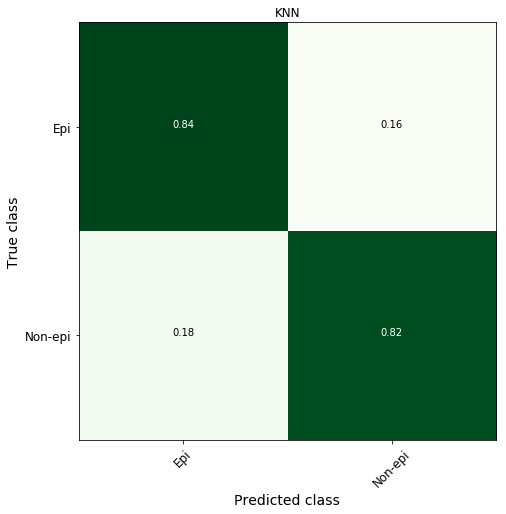

In [32]:
%matplotlib inline

# K Nearest Neighbors
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

testing_score = clf_knn.score(X_test, y_test)
predictions = clf_knn.predict(X_test) # Pour produire confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=['Epi', 'Non-epi'], normalize=True, title='KNN')
print("KNN testing accuracy: %0.2f" %testing_score)

In [33]:
# SVM

# Gridsearch
t0 = time.time()
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC())
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-5, 2, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range) 
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print('time gridsearch : ', time.time()-t0) # 9 min sans morpho feature (78% score) vs 5 min avec morpho feature (83% score)!

The best parameters are {'svc__C': 100.0, 'svc__gamma': 0.0021544346900318843} with a score of 0.89
time gridsearch :  149.68660736083984


In [45]:
%matplotlib qt
clf_svm = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=100, gamma=0.0021544346900318843))
clf_svm.fit(X_train, y_train)

testing_score = clf_svm.score(X_test, y_test)
predictions = clf_svm.predict(X_test) # Pour produire confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=['Epi', 'Non-epi'], normalize=True, title='SVM') # Utiliser np.unique(y_test, return_counts=True) pour voir si les classes sont bien assignées dans le graph
print("Training set score: %f" % clf_svm.score(X_train , y_train))
print("SVM testing accuracy: %0.2f" %testing_score)
print("Accuracy: %f" %metrics.accuracy_score(y_test, predictions))

Training set score: 0.930481
SVM testing accuracy: 0.87
Accuracy: 0.872340


In [35]:
svm_labels = clf_svm.predict(all_features)
#svm_proba = clf_svm.predict_proba(all_features)
clustered_nuclei_svm = np.copy(labels_final)

for i in range(len(props_final)) :
    bbox = props_final[i].bbox
    range_row = slice(bbox[0], bbox[2])
    range_col = slice(bbox[1], bbox[3])
    slices = (range_row, range_col)
    
#     if np.max(svm_proba[i]) < 0.7 :
#         clustered_nuclei_svm[slices][clustered_nuclei_svm[slices] > 1] = 3
#     else :
    clustered_nuclei_svm[slices][clustered_nuclei_svm[slices] > 1] = svm_labels[i]

In [48]:
all_features.shape, svm_labels.shape, len(props_final)

((3094, 26), (3094,), 3094)

In [51]:
# On enlève les noyaux non epithéliaux
only_epi_nuclei_svm = np.copy(labels_final)
for i in range(len(props_final)) :
    bbox = props_final[i].bbox
    range_row = slice(bbox[0], bbox[2])
    range_col = slice(bbox[1], bbox[3])
    slices = (range_row, range_col)
    
    if svm_labels[i] == 2 : # label 1 = epithéliaux, label 2 = non epithéliaux
        only_epi_nuclei_svm[slices][only_epi_nuclei_svm[slices] > 1] = 0
    else :
        only_epi_nuclei_svm[slices][only_epi_nuclei_svm[slices] > 1] = 1

plt.imshow(only_epi_nuclei_svm)

In [36]:
knn_labels = clf_knn.predict(all_features)
knn_proba = clf_knn.predict_proba(all_features)
clustered_nuclei_KNN = np.copy(labels_final)

for i in range(len(props_final)) :
    bbox = props_final[i].bbox
    range_row = slice(bbox[0], bbox[2])
    range_col = slice(bbox[1], bbox[3])
    slices = (range_row, range_col)
    
#     if np.max(knn_proba[i]) < 0.7 :
#         clustered_nuclei_KNN[slices][clustered_nuclei_KNN[slices] > 1] = 3
#     else :
    clustered_nuclei_KNN[slices][clustered_nuclei_KNN[slices] > 1] = knn_labels[i]

In [38]:
%matplotlib qt

f, ax = plt.subplots(1,3, figsize=(10,5), sharex=True,sharey=True)
ax = ax.ravel()
colormap = 'magma' # inferno
# ax[0].imshow(clustered_nuclei_kmeans, cmap=colormap)
# ax[0].set_title('k-means clustering', fontsize=BIGGER_SIZE)

ax[0].imshow(clustered_nuclei_KNN, cmap=colormap)
ax[0].set_title('KNN classification', fontsize=BIGGER_SIZE)

ax[1].imshow(clustered_nuclei_svm, cmap=colormap)
ax[1].set_title('SVM classification', fontsize=BIGGER_SIZE)

ax[2].imshow(matched)
ax[2].set_title('H&E', fontsize=BIGGER_SIZE)

for a in ax:
    a.axis('off')

plt.tight_layout()
#plt.savefig('/home/tien/Documents/presentations/labmeetings_Fred/figures/epi_nonepi_clustering.png')
plt.show()

### Test sur nouvelle image

In [32]:
# Save fitted models
#dump(clf_knn, 'knn_model.joblib')
dump(clf_svm, 'svm_model_epi_nuclei.joblib')

['svm_model_epi_nuclei.joblib']

In [9]:
os.getcwd()

'/home/tien/Documents/tests'

In [31]:
#knn_model = load('knn_model.joblib')
svm_model_epi_nuclei = load('/home/tien/Documents/tests/svm_model_epi_nuclei.joblib')

#knn_labels = knn_model.predict(all_features)
svm_labels = svm_model_epi_nuclei.predict(all_features)

In [32]:
#clustered_nuclei_KNN = np.copy(labels_final)
clustered_nuclei_svm = np.copy(labels_final)

# for i in range(len(props_final)) :
#     bbox = props_final[i].bbox
#     range_row = slice(bbox[0], bbox[2])
#     range_col = slice(bbox[1], bbox[3])
#     slices = (range_row, range_col)
    
#     clustered_nuclei_KNN[slices][clustered_nuclei_KNN[slices] > 1] = knn_labels[i]

for i in range(len(props_final)) :
    bbox = props_final[i].bbox
    range_row = slice(bbox[0], bbox[2])
    range_col = slice(bbox[1], bbox[3])
    slices = (range_row, range_col)

    clustered_nuclei_svm[slices][clustered_nuclei_svm[slices] > 1] = svm_labels[i]

In [33]:
%matplotlib qt

f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True,sharey=True)
ax = ax.ravel()
colormap = 'magma' # inferno
# ax[0].imshow(clustered_nuclei_kmeans, cmap=colormap)
# ax[0].set_title('k-means clustering', fontsize=BIGGER_SIZE)

# ax[0].imshow(clustered_nuclei_KNN, cmap=colormap)
# ax[0].set_title('KNN classification', fontsize=BIGGER_SIZE)

ax[0].imshow(clustered_nuclei_svm, cmap=colormap)
ax[0].set_title('SVM classification', fontsize=BIGGER_SIZE)

ax[1].imshow(matched)
ax[1].set_title('H&E', fontsize=BIGGER_SIZE)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [40]:
# produire figure pour meeting Fred
contours = measure.find_contours(nuclei_mask, level=np.mean(nuclei_mask))

f, ax = plt.subplots(1,2)
ax[0].imshow(matched)

ax[1].imshow(matched)
for n, contour in enumerate(contours) :
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, color='lime')
for a in ax:
    a.axis('off')
ax[0].set_title('H&E', fontsize=BIGGER_SIZE)
ax[1].set_title('Detected nuclei', fontsize=BIGGER_SIZE)
plt.show()

## <span style="color:purple"> HoG features </span>

In [293]:
fd, hog_image = hog(matched, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, feature_vector=False, multichannel=True)
# fd shape : # of cells x # orientations per cell
# hog_image shape : image shape

In [149]:
hog_image.shape, fd.shape

((2048, 2048), (256, 256, 1, 1, 9))

In [152]:
%matplotlib qt
f, ax = plt.subplots(1,2, sharex=True, sharey=True)

nuclei_cluster = np.array([[0,0,0],[0,0,0], [0,0,0], [0,0,255]])

ax[0].imshow(rescale_intensity(hog_image, in_range=(0,10)), cmap=plt.cm.gray)
ax[0].imshow(labels_copy, alpha=0.8)
ax[0].set_title('Histogram of Gradients')

ax[0].set_xticks(np.arange(0,2048,8))
ax[0].set_yticks(np.arange(0,2048,8))
ax[0].grid(color='r')

ax[1].imshow(matched)
ax[1].set_title('Matched RGB image')

# for a in ax:
#     a.axis('off')
plt.show()

In [10]:
%matplotlib qt
f, ax = plt.subplots(1,3,figsize=(15,15), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].imshow(rescale_intensity(hog_image, in_range=(0,10)), cmap=plt.cm.gray)
ax[1].imshow(labels_copy)

ax[2].imshow(matched)
plt.show()

In [383]:
f, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax = ax.ravel()
index = 1200

ax[0].imshow(labels_copy)
ax[0].imshow(hog_image, cmap=plt.cm.gray, alpha=0.8)

width = props_new[index].bbox[3] - props_new[index].bbox[1]
height = props_new[index].bbox[2] - props_new[index].bbox[0]
rect = patches.Rectangle((props_new[index].bbox[0:2][::-1]), width, height, edgecolor='y', facecolor='none')
ax[0].add_patch(rect)

ax[0].set_xticks(np.arange(0,2048,8))
ax[0].set_yticks(np.arange(0,2048,8))
ax[0].grid(color='r')

ax[1].imshow(matched)

plt.show()

In [294]:
pixel_step = 3
num_rows, num_cols, channels = matched.shape
mean_feat_nuclei = np.empty((0,9))
t0 = time.time()

for i in range(len(props_final)):

    bbox = props_final[i].bbox # donne le tuple : (min_row, min_col, max_row, max_col)

    range_row = slice(bbox[0], bbox[2]) # un slice, axe y sur imshow
    range_col = slice(bbox[1], bbox[3]) # un slice, axe x sur imshow

    if range_row.start != 0 : # si noyau ne commence pas au bord de l'image
        row_start = range_row.start - pixel_step
    else :
        row_start = range_row.start

    if range_row.stop != matched.shape[0] : # si noyau ne finit pas au bord de l'image
        row_stop = range_row.stop + pixel_step
    else :
        row_stop = range_row.stop


    if range_col.start != 0 : # si noyau ne commence pas au bord de l'image
        col_start = range_col.start - pixel_step
    else :
        col_start = range_col.start

    if range_col.stop != matched.shape[1] : # si noyau ne finit pas au bord de l'image
        col_stop = range_col.stop + pixel_step
    else :
        col_stop = range_col.stop
    
    # indices à donner au feature descriptor
    horizontal_edges = np.arange(int(col_start/8), int(col_stop/8)+1, 1)
    vertical_edges = np.arange(int(row_start/8), int(row_stop/8)+1, 1)
    
    # si un des edge est = 256
    if horizontal_edges[-1] == fd.shape[1] :
        horizontal_edges = np.delete(horizontal_edges, -1)
    if vertical_edges[-1] == fd.shape[0] :
        vertical_edges = np.delete(vertical_edges, -1)

    features_top = []
    features_bot = []
    features_left = []
    features_right = []

    for i in range(len(horizontal_edges)) :
        features_top.append(fd[vertical_edges[0], horizontal_edges[i], 0, 0])
        features_bot.append(fd[vertical_edges[-1], horizontal_edges[i], 0, 0])
    
    if len(vertical_edges) == 2 : # Revient à recalculer top et bot features. Donc pas de right left features
        features_nucleus = np.vstack((np.array(features_top), np.array(features_bot)))
    else :    
        for i in range(len(vertical_edges[1:-1])) : # exclue 1er et dernier éléments pcq'ils sont déjà comptés dans la boucle en haut
            features_left.append(fd[vertical_edges[i], horizontal_edges[0], 0, 0])
            features_right.append(fd[vertical_edges[i], horizontal_edges[-1], 0, 0])
        features_nucleus = np.vstack((np.array(features_top), np.array(features_bot), np.array(features_left), np.array(features_right)))
    
    mean_feat_nucleus = np.mean(features_nucleus, axis=0) # axis=0 column-wise, axis=1 row-wise
    
    # Liste qui contiendra tous les feature vector moyennés de chaque noyau. Shape : (# noyau x # orientations). Ici, (2553, 9)
    mean_feat_nuclei = np.vstack((mean_feat_nuclei, mean_feat_nucleus))
print('time : ', time.time() - t0)

time :  0.675572395324707


In [136]:
clustered_nuclei = np.copy(labels_copy)
bbox = props_new[25].bbox
range_row = slice(bbox[0], bbox[2])
range_col = slice(bbox[1], bbox[3])
slices = (range_row, range_col)
clustered_nuclei[slices]

array([[ 0,  0,  0,  0,  0,  0,  0,  0, 27, 27,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0,  0],
       [ 0,  0,  0,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0],
       [ 0,  0,  0,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0],
       [ 0,  0,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [ 0,  0,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [ 0,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [ 0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27],
       [ 0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27],
       [ 0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0],
       [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0],
       [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,